<a href="https://colab.research.google.com/github/tswast/code-snippets/blob/main/2025/overcastdata_freeze_dates.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# How to calculate the last frost date for a location?

Welcome to this companion notebook to the [OvercastData.com "When should you plant? Using mathematics to predict frost and save your garden"](https://www.overcastdata.com/en/blog/when-to-plant-mathematics-of-frost-dates) blog post. If you haven't read that first, I recommend it, as it provides important context for these simulations and probability calculations.

While these simulations are inpired by real-world NOAA Global Surface Summary of the Day (GSOD) data, this notebook focuses on simplified models. No access to cloud resources are required to run this code.

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/tswast/code-snippets/blob/main/2025/overcastdata_freeze_dates.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Colab logo"> Run in Colab
    </a>
  </td>
</table>

We use pandas and numpy to efficiently calculate and analyze these simulated seasons.

In [1]:
import random

import numpy as np
import pandas as pd
import seaborn as sns

rng = np.random.default_rng()

## Calculating the last freeze date


## Real temperature data


The next cell contains weather data at Chicago Midway covering the winter starting in 2023 and ending in 2024. If you'd like to try this exercise with another location, you can modify this query and run it for free using the [BigQuery sandbox](https://cloud.google.com/bigquery/docs/sandbox), no credit card required.

```sql
SELECT
`min` AS low_temp_f,
`date`,
FROM bigquery-public-data.noaa_gsod.gsod2023
WHERE stn = '725340' AND wban = '14819'  -- chicago midway
-- warmest day on average
AND `date` >= CAST('2023-07-12' AS DATE)
UNION ALL
(
SELECT
`min` AS low_temp_f,
`date`,
FROM bigquery-public-data.noaa_gsod.gsod2024
WHERE stn = '725340' AND wban = '14819'  -- chicago midway
-- warmest day on average
AND `date` < CAST('2024-07-12' AS DATE)
)
ORDER BY `date` ASC
```

In [2]:
midway_lows = pd.DataFrame({
    "low_temp_f": [64.0, 64.0, 69.1, 69.1, 66.9, 66.0, 62.1, 62.1, 72.0, 69.1, 64.0, 64.9, 69.1, 69.1, 75.9, 75.0, 72.0, 70.0, 66.9, 64.0, 69.1, 69.1, 66.0, 72.0, 72.0, 66.0, 69.1, 64.0, 66.0, 64.9, 71.1, 72.0, 66.9, 66.2, 63.0, 57.9, 64.9, 57.9, 63.0, 72.0, 72.0, 70.0, 75.0, 81.0, 71.1, 69.1, 64.9, 60.1, 63.0, 59.0, 54.0, 60.1, 64.0, 68.0, 71.1, 75.9, 69.1, 66.0, 60.1, 55.9, 55.0, 60.1, 55.9, 54.0, 52.0, 54.0, 60.1, 57.9, 53.1, 57.9, 61.0, 66.0, 64.9, 64.0, 59.0, 63.0, 64.0, 63.0, 64.0, 57.0, 59.0, 63.0, 63.0, 64.9, 71.1, 66.2, 48.9, 45.0, 45.0, 43.0, 39.9, 41.0, 53.1, 55.0, 51.8, 46.0, 48.0, 39.9, 46.0, 55.0, 52.0, 45.0, 42.1, 45.0, 57.9, 60.1, 64.0, 57.0, 39.9, 44.1, 33.1, 28.9, 27.0, 34.0, 44.1, 43.0, 36.0, 54.0, 46.0, 48.0, 42.1, 37.0, 30.9, 42.1, 39.0, 37.0, 43.0, 46.9, 44.1, 32.0, 36.0, 44.1, 42.1, 33.1, 34.0, 28.9, 28.9, 32.0, 21.9, 16.0, 19.0, 30.9, 44.1, 41.0, 39.0, 34.0, 33.8, 32.0, 35.6, 45.0, 43.0, 33.1, 28.9, 33.1, 23.0, 30.9, 36.0, 42.1, 39.0, 27.0, 18.0, 30.9, 35.1, 44.1, 44.6, 46.9, 51.1, 37.9, 30.9, 37.9, 39.0, 28.9, 32.0, 30.9, 28.0, 32.0, 28.0, 28.0, 30.9, 33.1, 32.0, 33.8, 30.9, 28.9, 28.0, 12.0, -9.0, -9.0, -5.1, 3.0, 19.0, 12.0, 5.0, 1.9, 19.9, 33.8, 33.8, 37.9, 39.0, 37.4, 37.0, 30.9, 36.0, 37.9, 36.0, 35.1, 30.9, 32.0, 33.1, 34.0, 30.0, 44.1, 43.0, 33.1, 30.0, 25.0, 30.0, 27.0, 39.0, 28.4, 14.0, 23.0, 26.1, 32.0, 46.0, 48.0, 37.9, 24.1, 32.0, 42.1, 55.9, 23.0, 19.9, 32.0, 37.0, 45.0, 54.0, 39.9, 39.2, 39.0, 44.1, 39.9, 30.9, 33.1, 48.0, 48.0, 45.0, 37.9, 39.9, 35.1, 26.1, 30.0, 34.0, 28.0, 30.9, 32.0, 33.1, 45.0, 39.9, 30.0, 30.9, 37.0, 44.1, 39.2, 42.1, 39.9, 35.1, 37.0, 37.0, 33.1, 39.9, 48.0, 52.0, 44.1, 50.0, 50.0, 43.0, 61.0, 50.0, 53.1, 59.0, 46.9, 43.0, 36.0, 35.1, 42.1, 57.0, 39.9, 34.0, 45.0, 57.0, 62.1, 61.0, 50.0, 64.9, 57.0, 59.0, 51.1, 54.0, 50.0, 60.1, 54.0, 53.1, 48.0, 52.0, 51.1, 64.0, 53.1, 54.0, 52.0, 60.1, 61.0, 68.0, 63.0, 63.0, 64.0, 57.0, 66.0, 59.0, 59.0, 59.0, 57.0, 55.9, 48.9, 54.0, 61.0, 60.1, 61.0, 73.0, 69.1, 64.9, 60.1, 59.0, 55.0, 55.0, 50.0, 68.0, 73.0, 68.0, 62.1, 71.1, 79.0, 79.0, 78.1, 71.1, 66.9, 73.9, 72.0, 66.9, 73.0, 75.0, 63.0, 64.9, 73.0, 62.1, 60.1, 66.9, 75.0, 73.9, 70.0, 64.9, 66.9, 71.1, 73.0, 66.9, 69.1],
    "date": pd.to_datetime(['2023-07-12', '2023-07-13', '2023-07-14', '2023-07-15', '2023-07-16', '2023-07-17', '2023-07-18', '2023-07-19', '2023-07-20', '2023-07-21', '2023-07-22', '2023-07-23', '2023-07-24', '2023-07-25', '2023-07-26', '2023-07-27', '2023-07-28', '2023-07-29', '2023-07-30', '2023-07-31', '2023-08-01', '2023-08-02', '2023-08-03', '2023-08-04', '2023-08-05', '2023-08-06', '2023-08-07', '2023-08-08', '2023-08-09', '2023-08-10', '2023-08-11', '2023-08-12', '2023-08-13', '2023-08-14', '2023-08-15', '2023-08-16', '2023-08-17', '2023-08-18', '2023-08-19', '2023-08-20', '2023-08-21', '2023-08-22', '2023-08-23', '2023-08-24', '2023-08-25', '2023-08-26', '2023-08-27', '2023-08-28', '2023-08-29', '2023-08-30', '2023-08-31', '2023-09-01', '2023-09-02', '2023-09-03', '2023-09-04', '2023-09-05', '2023-09-06', '2023-09-07', '2023-09-08', '2023-09-09', '2023-09-10', '2023-09-11', '2023-09-12', '2023-09-13', '2023-09-14', '2023-09-15', '2023-09-16', '2023-09-17', '2023-09-18', '2023-09-19', '2023-09-20', '2023-09-21', '2023-09-22', '2023-09-23', '2023-09-24', '2023-09-25', '2023-09-26', '2023-09-27', '2023-09-28', '2023-09-29', '2023-09-30', '2023-10-01', '2023-10-02', '2023-10-03', '2023-10-04', '2023-10-05', '2023-10-06', '2023-10-07', '2023-10-08', '2023-10-09', '2023-10-10', '2023-10-11', '2023-10-12', '2023-10-13', '2023-10-14', '2023-10-15', '2023-10-16', '2023-10-17', '2023-10-18', '2023-10-19', '2023-10-20', '2023-10-21', '2023-10-22', '2023-10-23', '2023-10-24', '2023-10-25', '2023-10-26', '2023-10-27', '2023-10-28', '2023-10-29', '2023-10-30', '2023-10-31', '2023-11-01', '2023-11-02', '2023-11-03', '2023-11-04', '2023-11-05', '2023-11-06', '2023-11-07', '2023-11-08', '2023-11-09', '2023-11-10', '2023-11-11', '2023-11-12', '2023-11-13', '2023-11-14', '2023-11-15', '2023-11-16', '2023-11-17', '2023-11-18', '2023-11-19', '2023-11-20', '2023-11-21', '2023-11-22', '2023-11-23', '2023-11-24', '2023-11-25', '2023-11-26', '2023-11-27', '2023-11-28', '2023-11-29', '2023-11-30', '2023-12-01', '2023-12-02', '2023-12-03', '2023-12-04', '2023-12-05', '2023-12-06', '2023-12-07', '2023-12-08', '2023-12-09', '2023-12-10', '2023-12-11', '2023-12-12', '2023-12-13', '2023-12-14', '2023-12-15', '2023-12-16', '2023-12-17', '2023-12-18', '2023-12-19', '2023-12-20', '2023-12-21', '2023-12-22', '2023-12-23', '2023-12-24', '2023-12-25', '2023-12-26', '2023-12-27', '2023-12-28', '2023-12-29', '2023-12-30', '2023-12-31', '2024-01-01', '2024-01-02', '2024-01-03', '2024-01-04', '2024-01-05', '2024-01-06', '2024-01-07', '2024-01-08', '2024-01-09', '2024-01-10', '2024-01-11', '2024-01-12', '2024-01-13', '2024-01-14', '2024-01-15', '2024-01-16', '2024-01-17', '2024-01-18', '2024-01-19', '2024-01-20', '2024-01-21', '2024-01-22', '2024-01-23', '2024-01-24', '2024-01-25', '2024-01-26', '2024-01-27', '2024-01-28', '2024-01-29', '2024-01-30', '2024-01-31', '2024-02-01', '2024-02-02', '2024-02-03', '2024-02-04', '2024-02-05', '2024-02-06', '2024-02-07', '2024-02-08', '2024-02-09', '2024-02-10', '2024-02-11', '2024-02-12', '2024-02-13', '2024-02-14', '2024-02-15', '2024-02-16', '2024-02-17', '2024-02-18', '2024-02-19', '2024-02-20', '2024-02-21', '2024-02-22', '2024-02-23', '2024-02-24', '2024-02-25', '2024-02-26', '2024-02-27', '2024-02-28', '2024-02-29', '2024-03-01', '2024-03-02', '2024-03-03', '2024-03-04', '2024-03-05', '2024-03-06', '2024-03-07', '2024-03-08', '2024-03-09', '2024-03-10', '2024-03-11', '2024-03-12', '2024-03-13', '2024-03-14', '2024-03-15', '2024-03-16', '2024-03-17', '2024-03-18', '2024-03-19', '2024-03-20', '2024-03-21', '2024-03-22', '2024-03-23', '2024-03-24', '2024-03-25', '2024-03-26', '2024-03-27', '2024-03-28', '2024-03-29', '2024-03-30', '2024-03-31', '2024-04-01', '2024-04-02', '2024-04-03', '2024-04-04', '2024-04-05', '2024-04-06', '2024-04-07', '2024-04-08', '2024-04-09', '2024-04-10', '2024-04-11', '2024-04-12', '2024-04-13', '2024-04-14', '2024-04-15', '2024-04-16', '2024-04-17', '2024-04-18', '2024-04-19', '2024-04-20', '2024-04-21', '2024-04-22', '2024-04-23', '2024-04-24', '2024-04-25', '2024-04-26', '2024-04-27', '2024-04-28', '2024-04-29', '2024-04-30', '2024-05-01', '2024-05-02', '2024-05-03', '2024-05-04', '2024-05-05', '2024-05-06', '2024-05-07', '2024-05-08', '2024-05-09', '2024-05-10', '2024-05-11', '2024-05-12', '2024-05-13', '2024-05-14', '2024-05-15', '2024-05-16', '2024-05-17', '2024-05-18', '2024-05-19', '2024-05-20', '2024-05-21', '2024-05-22', '2024-05-23', '2024-05-24', '2024-05-25', '2024-05-26', '2024-05-27', '2024-05-28', '2024-05-29', '2024-05-30', '2024-05-31', '2024-06-01', '2024-06-02', '2024-06-03', '2024-06-04', '2024-06-05', '2024-06-06', '2024-06-07', '2024-06-08', '2024-06-09', '2024-06-10', '2024-06-11', '2024-06-12', '2024-06-13', '2024-06-14', '2024-06-15', '2024-06-16', '2024-06-17', '2024-06-18', '2024-06-19', '2024-06-20', '2024-06-21', '2024-06-22', '2024-06-23', '2024-06-24', '2024-06-25', '2024-06-26', '2024-06-27', '2024-06-28', '2024-06-29', '2024-06-30', '2024-07-01', '2024-07-02', '2024-07-03', '2024-07-04', '2024-07-05', '2024-07-06', '2024-07-07', '2024-07-08', '2024-07-09', '2024-07-10', '2024-07-11']
    ),
})
midway_lows.head()

,low_temp_f,date
0,64.0,2023-07-12
1,64.0,2023-07-13
2,69.1,2023-07-14
3,69.1,2023-07-15
4,66.9,2023-07-16


In [3]:
midway_lows.dtypes

,0
low_temp_f,float64
date,datetime64[ns]


To calculate the last freeze date, it's helpful reverse the order of the rows so that you're working backwards from summer, spring, then winter. That's because it's actually a bit easier to calculate the first freeze with the [cumulative sum function](https://pandas.pydata.org/docs/reference/api/pandas.Series.cumsum.html) than it is to get the last freeze.

In [4]:
midway_lows_reversed = midway_lows.set_index("date").sort_index(ascending=False)
midway_lows_reversed.head()

,low_temp_f
date,
2024-07-11,69.1
2024-07-10,66.9
2024-07-09,73.0
2024-07-08,71.1
2024-07-07,66.9


Freezing temperature is 32 °F. It'd be helpful to add a column indicating whether the temperature dropped to freezing.

In [5]:
midway_lows_reversed["freezing"] = midway_lows_reversed["low_temp_f"] <= 32
midway_lows_reversed.head()

,low_temp_f,freezing
date,,
2024-07-11,69.1,False
2024-07-10,66.9,False
2024-07-09,73.0,False
2024-07-08,71.1,False
2024-07-07,66.9,False


To find the last freeze date, we'll take the cumulative sum. This will count how many freezing days we've had so far.

In [6]:
midway_lows_reversed["freezing_days"] = midway_lows_reversed["freezing"].cumsum()
midway_lows_reversed.head()

,low_temp_f,freezing,freezing_days
date,,,
2024-07-11,69.1,False,0
2024-07-10,66.9,False,0
2024-07-09,73.0,False,0
2024-07-08,71.1,False,0
2024-07-07,66.9,False,0


If we find the row where the count is $1$, that'd be the first frost date, but since we reversed the rows, it's the last frost date.

In [7]:
offset = midway_lows_reversed["freezing_days"].searchsorted(1)
midway_lows_reversed.index[offset]

Timestamp('2024-03-28 00:00:00')

## Simulating frost with dice

Let's roll a 6 sided dice for the weather. If it's a 1, it freezes, otherwise it's warm enough for plants to grow.

In [8]:
total_simulations = 100_000
simulation_length = 200
simulations = rng.integers(1, 7, size=(total_simulations, simulation_length))
simulations

array([[2, 2, 6, ..., 4, 3, 1],
       [1, 3, 5, ..., 6, 5, 6],
       [2, 3, 5, ..., 4, 5, 6],
       ...,
       [4, 1, 5, ..., 4, 4, 6],
       [5, 4, 6, ..., 5, 5, 3],
       [4, 3, 6, ..., 2, 6, 1]])

To assist future analysis, `calculate_lifetimes` calculates the first frost since `starting_day` using a similar cumulative sum technique we used to calculate the last frost date for Chicago Midway.

In [9]:
def calculate_lifetimes(values: np.array, starting_day: int = 0):
    """Calculate how many days there were before frost in each row."""
    simulation_length = values.shape[1]
    return np.sum(
        (
            # Count the number of days in a row that it was not frozen.
            np.cumsum(
              # Was the day not frozen?
              (values[:, starting_day:] != 1),
              axis=1,
            )
            # If the count doesn't equal the column number,
            # we know there must have been a freeze at some point,
            # so the plants haven't survived to this day.
            == np.arange(1, simulation_length - starting_day + 1)
        ),
        axis=1
    )

In [10]:
lifetimes = calculate_lifetimes(simulations)
lifetimes

array([ 7,  0,  4, ...,  1, 14,  7])

This chart shows how long the plants lasted until a freeze if planted on the first day of the season. Since the chance of freeze doesn't change in this simulation, we'd see an identical chart if starting on any day of the simulation.

<Axes: ylabel='Density'>

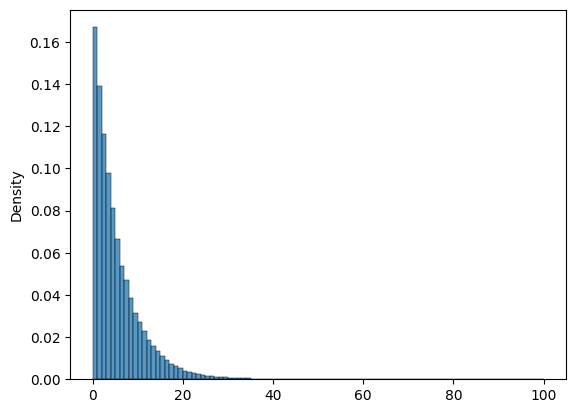

In [11]:
sns.histplot(lifetimes, bins=100, stat="density", binrange=(0, 100))

On average, we'd expect freeze in every $1/6$ days. This means that the plant should live 5 days before freezing, which is what we observe here.

In [12]:
lifetimes.mean()

np.float64(4.98654)

No plant made it to 100 days in our simulation.

In [13]:
(lifetimes >= 100).sum()

np.int64(0)

How long did the luckiest plant live?

In [14]:
lifetimes.max()

np.int64(81)

Theoretically, the chance of a particular day $n$ being the first frost date, it's $1/6$ that it freezes and $(5/6)^{n-1}$ that it doesn't freeze on all the days prior.

This line should look similar to the histogram above.

<Axes: >

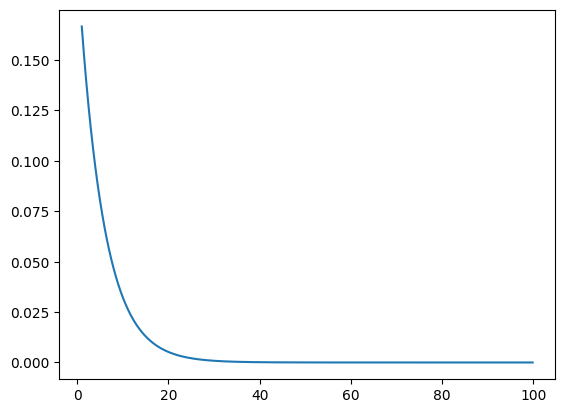

In [15]:
eq = (1/6) * (5/6) ** (np.arange(1, 100, 0.1) - 1)
sns.lineplot(x=np.arange(1, 100, 0.1), y=eq)

## Slightly more realistic freeze probabilities

We know the probability of freeze should decrease over time as spring turns to summer. What's a simple model of that we could use?

Starting with the first day of spring, we have a $(1/1)$ chance of freezing. On the second day, we have a $(1/2)$ chance. On the third day, we have a $(1/3)$ chance, and so on. After 100 days, it's summer and let's assume it never freezes after that. Let's try a few different simulations.

In [16]:
total_simulations = 100_000
simulation_length = 200
summer_start = 100

columns = []
for col in range(1, simulation_length + 1):
  if col < summer_start:
    columns.append(
      # Just like the previous , if we
      # roll a 1, it freezes. But this time
      # we roll a dice with a different number
      # of sides per day.
      rng.integers(1, col + 1, size=(total_simulations, 1))
    )
  else:
    columns.append(
      np.ones((total_simulations, 1)) + 1  # Never freeze.
    )

simulations = np.concatenate(columns, axis=1)

First, if we plant on day 1, all of our crops are guaranteed to freeze. What happens if we plant on day 2?

<Axes: ylabel='Density'>

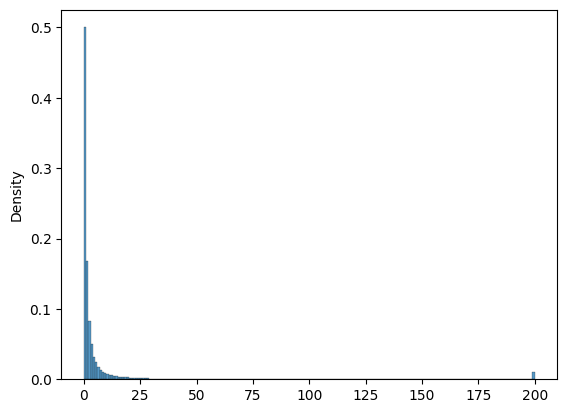

In [17]:
# Note that Python is zero indexed,
# so we use `starting_day=1` to calculate what happens
# if we plant on day 2.
starting_day = 1
lifetimes = calculate_lifetimes(simulations, starting_day=starting_day)
sns.histplot(lifetimes, bins=200, stat="density", binrange=(0, 200))

Some lucky plants do make it the whole season in this simulation.

In [18]:
np.max(lifetimes)

np.int64(199)

But on average, they don't make it very far.

In [19]:
lifetimes.mean()

np.float64(5.15624)

We ran a bunch of simulations. When was the last freeze date in each? How often was each day the last freeze date in this simulation?

<Axes: ylabel='Density'>

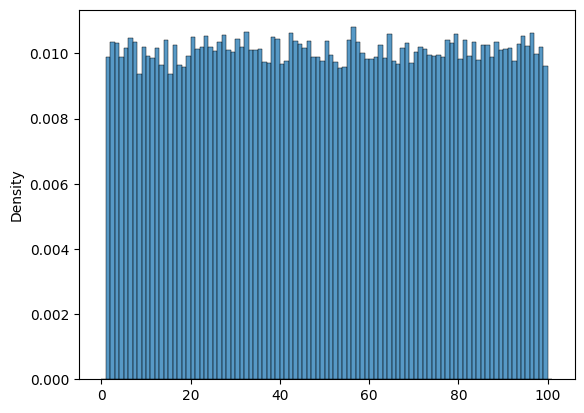

In [20]:
# On which days did it freeze?
frozen = simulations == 1

# We reverse because it's a bit
# easier to calculate the first
# freeze with cumsum.
frozen_reversed = frozen[:,::-1]

# How many days have frozen so far in the season?
frozen_days = np.cumsum(frozen_reversed, axis=1)

# Because we're going in reverse,
# the days after the last frost will
# have a count of 0.
up_to_last_frost = frozen_days > 0
days_up_to_last_frost = np.sum(up_to_last_frost, axis=1)
sns.histplot(
    days_up_to_last_frost,
    bins=101, stat="density", binrange=(0, 101),
)

In [21]:
days_up_to_last_frost.mean()

np.float64(50.03884)

We accidentally made every day of the season equally likely to be the last frost date! Why is this?

- The chance of freezing on any particular day is $1/n$ with $n \in [1, 100]$.

- The chance of _not_ freezing is $1 - 1/n$, which is $n/n - 1/n$, which is also $(n - 1) / n$.

This means the chance of being the last frost date is

$(1/n) \prod_{i=n+1}^{100} (i - 1) / i$.

When we expand the product, we see that most terms cancel out.

$\frac{1}{n} \frac{n + 1 - 1}{n + 1} \frac{n + 2 - 1}{n + 2} ... \frac{99 - 1}{99} \frac{100 - 1}{100}$

$\frac{1}{n} \frac{n}{n + 1} \frac{n + 1}{n + 2} ... \frac{98}{99} \frac{99}{100}$

$ \require{cancel} \frac{1}{\cancel{n}} \frac{\cancel{n}}{\cancel{n + 1}} \frac{\cancel{n + 1}}{\cancel{n + 2}} ... \frac{\cancel{98}}{\cancel{99}} \frac{\cancel{99}}{100} = \frac{1}{100}.$

## Chicago-inspired freeze probabilities: simulating closer to real life

Looking at the [Chicago freeze probabilities](https://www.overcastdata.com/en/loc/chicago-il-usa/#frost), the freeze probability starts at around 90 and decreases to basically 0 over around 90 days.

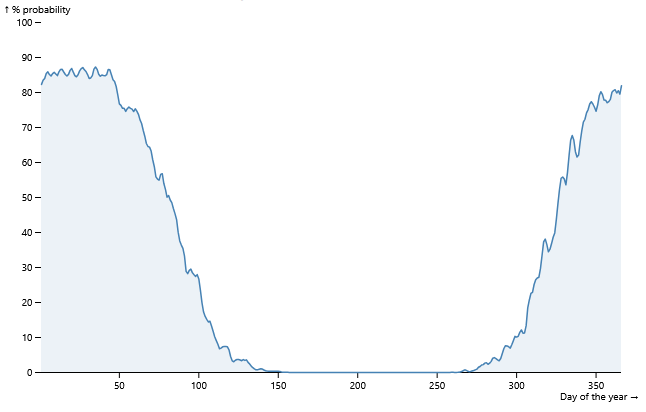

To keep the math perhaps a bit easier to follow, let's try going from 100 to 0 in 100 days.

In [36]:
# Try some simulations with probabilities closer to what's observed in Chicago.
total_simulations = 100_000
simulation_length = 200
summer_start = 100

# Go from 99/100 to 0/100 in 100 steps.
# That should be a 1/100 change in probability each step.
probabilities = np.linspace(0.99, 0, num=summer_start, endpoint=True)

days = []

# Simulate it one day at a time to make the comparisons a bit easier.
# We calculate the same day of the season over all 100,000 simulations
# at the same time to save time.
for day in range(1, simulation_length + 1):
  if day < summer_start:
    days.append(
      np.where(
          (
            # Pick a random floating point number between 0 and 1.
            # If this number is less than the probability of a freeze,
            # then we have a freeze, otherwise not.
            rng.uniform(
                0,
                1,
                size=(total_simulations, 1),
            ) < probabilities[day - 1]
          ),
          1,
          2,
      )
    )
  else:
    days.append(
      # Never freeze after the probability reaches 0.
      np.ones((total_simulations, 1)) + 1
    )

simulations = np.concatenate(days, axis=1)

How long would corn planted on day 50 live?

<Axes: ylabel='Density'>

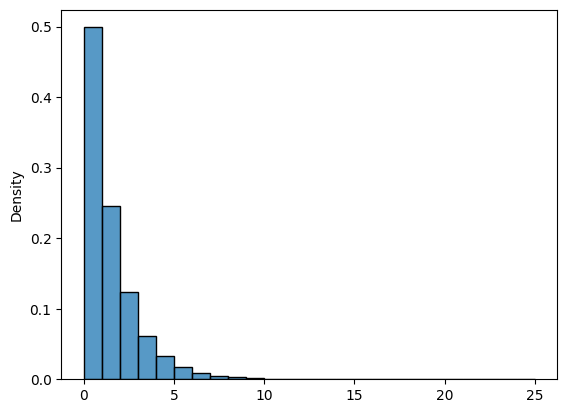

In [37]:
starting_day = 49  # Day 50 since the array is 0-indexed.
lifetimes = calculate_lifetimes(simulations, starting_day=starting_day)
sns.histplot(lifetimes, bins=25, stat="density", binrange=(0, 25))

In [38]:
lifetimes.max()

np.int64(25)

Just like with the real life data from Chicago Midway, we can calculate the last freeze date on these simulated seasons. The only difference here is that we're checking to see if we rolled a "1" instead of if the temperature is below 32 ºF.

<Axes: ylabel='Density'>

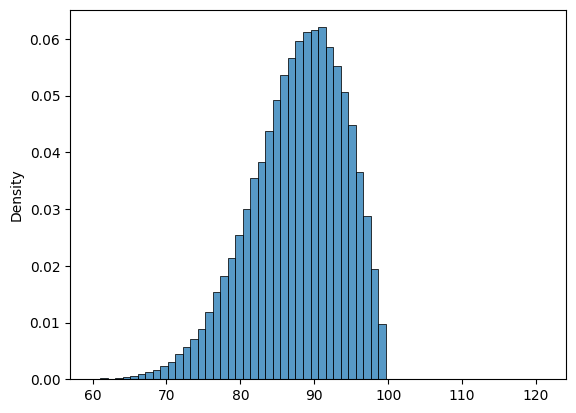

In [39]:
frozen = simulations == 1
frozen_reversed = frozen[:,::-1]
frozen_days = np.cumsum(frozen_reversed, axis=1)
before_last_frost = frozen_days > 0
days_before_last_frost = np.sum(before_last_frost, axis=1)
sns.histplot(days_before_last_frost, bins=60, stat="density", binrange=(60, 121))

In [40]:
np.median(days_before_last_frost)

np.float64(88.0)

 The chance of a particular day $i$ being the last frost date is the chance it freezes on that day and the all of the days following do not freeze: $p_i (1 - p_{i + 1}) (1 - p_{i + 2}) ... (1 - p_{200})$.

 Avoid the multiplication of very small numbers by using the fact that $a b = e^{\log{ab}} = e^{\log(a) + \log(b)}$.

 The shape of this line should look very similar to the histogram of last freeze dates.

<Axes: >

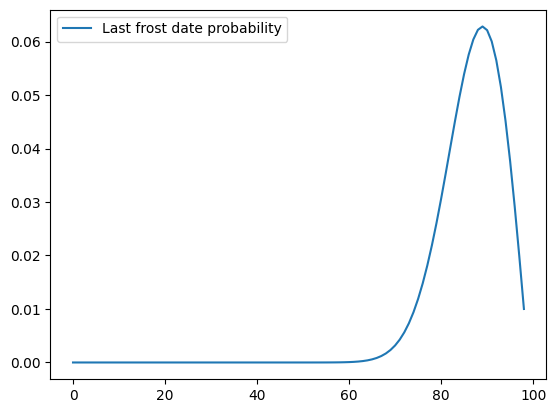

In [41]:
reversed_probabilities = probabilities[::-1]

last_frost_date_probability = np.exp(
    np.cumsum(
        np.log(1.0 - reversed_probabilities[:-1])
    )
    + np.log(reversed_probabilities[1:])
)[::-1]
sns.lineplot(last_frost_date_probability, label="Last frost date probability")

Let's check that we calculated the probabilities correctly. If all went well, they should sum to 1.0.

In [42]:
np.sum(last_frost_date_probability)

np.float64(1.0)

To determine the probabilities of different last freeze dates, it's useful to take the cumulative sum. This tells us the probability of a last freeze date being at a particular date or before.

<Axes: >

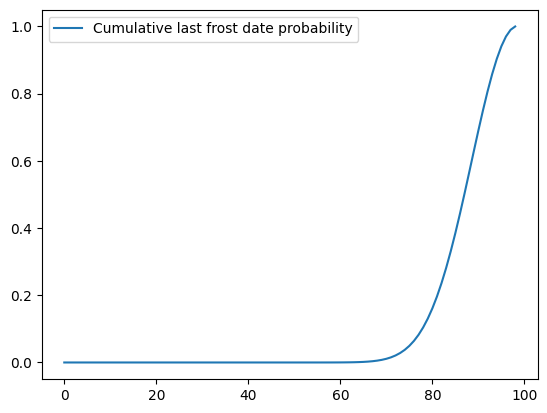

In [43]:
cdf = np.cumsum(last_frost_date_probability)
sns.lineplot(cdf, label="Cumulative last frost date probability")

If we look for 0.5, that should give us the expected average last freeze date. The array is zero indexed, but we want which day of the season, which starts at day 1.

In [44]:
np.searchsorted(cdf, 0.5) + 1

np.int64(88)

Likewise, looking for 0.95 should give us only a 1/20 chance that corn planted on this date would encounter a freeze afterwards.

In [45]:
np.searchsorted(cdf, 0.95) + 1

np.int64(97)